# Preprocessing Sensor's Space

In [ ]:
# -----------------------
# Set working environment :
# ----------------------

import os
os.chdir("/home/INT/salmi.i/Téléchargements/Script Python")
print("Répertoire de travail actuel :", os.getcwd())

In [ ]:
# -----------------------
# Libraries importation :
# ----------------------
import numpy as np
import scipy.signal as spsg
import scipy.io as sio
import matplotlib.pyplot as plt
import networkx as nx
import mne
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, GridSearchCV,  cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
import time
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import hilbert
import seaborn as sns

## Load Data STOP-IN

In [ ]:
# -----------------------
# Infos general :
# -----------------------
print('### TEST ###')
i_sub = 60
type_mov = 'SI'
type_space = 'source'
type_classif = 'socfacil'
freq_band = 'alpha'
# boolean for classification type
bool_socfacil = type_classif=='socfacil'
# check if directory for results exists; if not create
res_dir = 'res/'
os.makedirs(res_dir, exist_ok=True)
print('sub, classif type:', i_sub, type_classif)\
# colors for plots
cmapcolours = ['Blues','Greens','Oranges']

#measure_labels = ['pow','cov','corr']
measure_labels = ['pow','corr']
n_measures = len(measure_labels)
freq_bands = ['alpha','beta','gamma']
n_bands = len(freq_bands)

# -----------------------
# Data load :
# -----------------------

dir_path = './' 
file_name = 'dataClean-ICA-{}-T1.mat'.format(i_sub)

# sensor space: dataSorted4; source space: ic_data4
#var_dict = sio.loadmat(dir_path+file_name, variable_names=('ic_data', 'blockOrder')) 

# sensor space: dataSorted; source space: ic_data4; block index: 
var_dict = sio.loadmat(dir_path+file_name, variable_names=('dataSorted', 'blockOrder')) 
ts_tmp_si = var_dict['dataSorted'].reshape([128, 1600, 108, 12]) # [N,T,n_trials,block_index]
blk_index = var_dict['blockOrder'].flatten() # [block_index]
# get relevant blocks and labels for classification
# STOP-IN: solo=2, easy=4/8, hard=6/10
# PUNCH-THROUGH: solo=1, easy=3/7, hard=5/9
# ALL: pool STOP-IN and PUNCH-THROUGH
if type_mov=='SI':
    if bool_socfacil:
        # presence of social partner
        sel_blk = np.mod(blk_index,2)==0
        blk_labels = np.array(blk_index>2, dtype=int)
    else:
        # skill of social partner
        sel_blk = np.logical_and(np.mod(blk_index,2)==0, blk_index>2)
        blk_labels = np.array(np.logical_or(blk_index==6, blk_index==10), dtype=int)
elif type_mov=='PT':
    if bool_socfacil:
        # presence of social partner
        sel_blk = np.mod(blk_index,2)==1
        blk_labels = np.array(blk_index>2, dtype=int)
    else:
        # skill of social partner
        sel_blk = np.logical_and(np.mod(blk_index,2)==1, blk_index>2)
        blk_labels = np.array(np.logical_or(blk_index==5, blk_index==9), dtype=int)
else:
    raise ValueError('only SI or PT movement allowed')
    
# filter blocks
ts_tmp_si = ts_tmp_si[:,:,:,sel_blk]
blk_labels = blk_labels[sel_blk]
print(blk_index)
print(blk_labels)
print(ts_tmp_si[0,0,0,:])
print(ts_tmp_si.shape)

blk_index = np.array([2,2,4,8,6,10])
# Initializing labels
blk_labels = np.zeros_like(blk_index, dtype=int)
# Aassignment of labels based on conditions
if type_mov == 'SI' :
    #STOP IN
    for i, block in enumerate (blk_index) : 
        if block <= 2 : 
            blk_labels[i] = 0 # Absence of partner
        elif block in [4, 8]:
            blk_labels[i] = 1 # Easy Partner
        elif block in [6, 10]:
            blk_labels[i] = 2 # HArd partner
elif type_mov == 'PT' : 
    #PUNCH TROUGH       
    for i, block in enumerate(blk_index):
        if block <= 1 :
            blk_labels[i] = 0 # Absence of partner
        elif block in [3, 7]:
            blk_labels[i] = 1 # Easy Partner
        elif block in [5, 9]:
            blk_labels[i] = 2 # HArd partner
else:
    raise ValueError('only SI or PT movement allowed')
# Filter blocks select
sel_blk = blk_labels != -1 #-1 indicates an unselected block
#Adjust the size of sel_blk to match the size of the blocks in ts_tmp
sel_blk = sel_blk[:ts_tmp_si.shape[3]]
ts_tmp_si = ts_tmp_si[:,:,:,sel_blk]
blk_labels = blk_labels[sel_blk]
print(blk_index)
print(blk_labels)
print(ts_tmp_si[0,0,0,:])
print(ts_tmp_si.shape)

# -----------------------
# Discard silent and nan trials :
# -----------------------
invalid_trials = np.logical_or(np.abs(ts_tmp_si[0,0,:,:]).max(axis=1)==0, np.isnan(ts_tmp_si[0,0,:,0]))
valid_trials = np.logical_not(invalid_trials)
ts_tmp_si = ts_tmp_si[:,:,valid_trials,:]
n_trials = valid_trials.sum()
# check for good cleaning
print('remaining nans:', np.sum(np.isnan(ts_tmp_si)))
print(ts_tmp_si.shape)
print(ts_tmp_si[0,0,0,:])

## Load Data PUNCH-TROUGh

In [ ]:
# -----------------------
# General Info:
# -----------------------
print('### TEST ###')
i_sub = 60
type_mov = 'PT'
type_space = 'source'
type_classif = 'socfacil'
freq_band = 'alpha'
# Boolean for classification type
bool_socfacil = type_classif == 'socfacil'
# Check if directory for results exists; if not, create it
res_dir = 'res/'
os.makedirs(res_dir, exist_ok=True)
print('sub, classif type:', i_sub, type_classif)

# Colors for plots
cmapcolours = ['Blues', 'Greens', 'Oranges']

# Measure labels
measure_labels = ['pow', 'corr']
n_measures = len(measure_labels)
freq_bands = ['alpha', 'beta', 'gamma']
n_bands = len(freq_bands)

# -----------------------
# Data Load:
# -----------------------

dir_path = './'
file_name = 'dataClean-ICA-{}-T1.mat'.format(i_sub)

# Sensor space: dataSorted4; source space: ic_data4
# var_dict = sio.loadmat(dir_path+file_name, variable_names=('ic_data', 'blockOrder'))

# Sensor space: dataSorted; source space: ic_data4; block index:
var_dict = sio.loadmat(dir_path+file_name, variable_names=('dataSorted', 'blockOrder'))
ts_tmp_pt = var_dict['dataSorted'].reshape([128, 1600, 108, 12])  # [N, T, n_trials, block_index]
blk_index = var_dict['blockOrder'].flatten()  # [block_index]

# Get relevant blocks and labels for classification
# STOP-IN: solo=2, easy=4/8, hard=6/10
# PUNCH-THROUGH: solo=1, easy=3/7, hard=5/9
# ALL: pool STOP-IN and PUNCH-THROUGH
if type_mov == 'SI':
    if bool_socfacil:
        # Presence of social partner
        sel_blk = np.mod(blk_index, 2) == 0
        blk_labels = np.array(blk_index > 2, dtype=int)
    else:
        # Skill of social partner
        sel_blk = np.logical_and(np.mod(blk_index, 2) == 0, blk_index > 2)
        blk_labels = np.array(np.logical_or(blk_index == 6, blk_index == 10), dtype=int)
elif type_mov == 'PT':
    if bool_socfacil:
        # Presence of social partner
        sel_blk = np.mod(blk_index, 2) == 1
        blk_labels = np.array(blk_index > 2, dtype=int)
    else:
        # Skill of social partner
        sel_blk = np.logical_and(np.mod(blk_index, 2) == 1, blk_index > 2)
        blk_labels = np.array(np.logical_or(blk_index == 5, blk_index == 9), dtype=int)
else:
    raise ValueError('only SI or PT movement allowed')

# Filter blocks
ts_tmp_pt = ts_tmp_pt[:, :, :, sel_blk]
blk_labels = blk_labels[sel_blk]
print(blk_index)
print(blk_labels)
print(ts_tmp_pt[0, 0, 0, :])
print(ts_tmp_pt.shape)

blk_index = np.array([1, 1, 3, 7, 5, 9])
# Initialize labels
blk_labels = np.zeros_like(blk_index, dtype=int)
# Assign labels based on conditions
if type_mov == 'SI':
    # STOP IN
    for i, block in enumerate(blk_index):
        if block <= 2:
            blk_labels[i] = 0  # Absence of partner
        elif block in [4, 8]:
            blk_labels[i] = 1  # Easy partner
        elif block in [6, 10]:
            blk_labels[i] = 2  # Difficult partner
elif type_mov == 'PT':
    # PUNCH THROUGH
    for i, block in enumerate(blk_index):
        if block <= 1:
            blk_labels[i] = 0  # Absence of partner
        elif block in [3, 7]:
            blk_labels[i] = 1  # Easy partner
        elif block in [5, 9]:
            blk_labels[i] = 2  # Difficult partner
else:
    raise ValueError('only SI or PT movement allowed')

# Filter selected blocks
sel_blk = blk_labels != -1  # -1 indicates a non-selected block
# Adjust the size of sel_blk to match the block dimension in ts_tmp
sel_blk = sel_blk[:ts_tmp_pt.shape[3]]
ts_tmp_pt = ts_tmp_pt[:, :, :, sel_blk]
blk_labels = blk_labels[sel_blk]
print(blk_index)
print(blk_labels)
print(ts_tmp_pt[0, 0, 0, :])
print(ts_tmp_pt.shape)

# -----------------------
# Discard silent and nan trials:
# -----------------------
invalid_trials = np.logical_or(np.abs(ts_tmp_pt[0, 0, :, :]).max(axis=1) == 0, np.isnan(ts_tmp_pt[0, 0, :, 0]))
valid_trials = np.logical_not(invalid_trials)
ts_tmp_pt = ts_tmp_pt[:, :, valid_trials, :]
n_trials = valid_trials.sum()
# Check for good cleaning
print('remaining nans:', np.sum(np.isnan(ts_tmp_pt)))
print(ts_tmp_pt.shape)
print(ts_tmp_pt[0, 0, 0, :])


## Make Montage GSN129

In [ ]:
# -----------------------#
# Get the metric for dig_montage :
# -----------------------
montage = mne.channels.read_custom_montage('GSN129.sfp')
ch_pos = montage._get_ch_pos() 
#print(ch_pos)

# -----------------------
# Create dig_montage :
# -----------------------
montage = mne.channels.make_dig_montage(ch_pos=ch_pos,
                                  nasion=[ 0.        ,  0.09821842, -0.02554916], 
                                  lpa=[-0.07266855,  0.00043744, -0.03520521],
                                  rpa=[ 0.07266855,  0.00043744, -0.03520521],  
                                  hsp=None,
                                  hpi=None, 
                                  coord_frame='unknown')
print(montage.get_positions())

# -----------------------
# Montage plot  :
# -----------------------

montage.plot()  # 2D

fig = montage.plot(kind="3d", show=False)  # 3D
fig = fig.gca().view_init(azim=70, elev=15)  # set view angle for tutorial

![alt text](image.png)

![alt text](image-1.png)

## Create Info object

In [ ]:
#-----------------------# 
# Create info  :
# ----------------------# 
sfreq = 500.0 # np.diff(X).mean() if not sure about the freq
info = mne.create_info( ch_names=montage.ch_names, sfreq=sfreq, ch_types="eeg", verbose = None)
info["bads"] = ["EEG94","EEG99","EEG127"]
info.set_montage(montage)
print(info)
#info.save("info_eeg_gsn129-info.fif")

<Info | 9 non-empty values
 bads: 3 items (EEG94, EEG99, EEG127)
 ch_names: EEG1, EEG2, EEG3, EEG4, EEG5, EEG6, EEG7, EEG8, EEG9, EEG10, ...
 chs: 128 EEG
 custom_ref_applied: False
 dig: 131 items (3 Cardinal, 128 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 500.0 Hz
>

## Create Event Object

In [ ]:

# Parameters
# resolution 2ms, trial starting 0.8s before go signal

start = 400 # time of go event in trial (in timepoint)
increment = 1600 # time points per trial
num_events = 214
event_id_solo = {"solo":1}
event_id_easy = {"easy":2}
event_id_hard = {"hard":3}
baseline= (-0.8,0)

# Creating array for each event 
events_solo = np.array([(start + i * increment, 0, 1) for i in range(num_events)])
events_easy = np.array([(start + i * increment, 0, 2) for i in range(num_events)])
events_hard = np.array([(start + i * increment, 0, 3) for i in range(num_events)])

print(events_solo)
print(events_easy)
print(events_hard)

[[   400      0      1]
 [  2000      0      1]
 [  3600      0      1]
 [  5200      0      1]
 [  6800      0      1]
 [  8400      0      1]
 [ 10000      0      1]
 [ 11600      0      1]
 [ 13200      0      1]
 [ 14800      0      1]
 [ 16400      0      1]
 [ 18000      0      1]
 [ 19600      0      1]
 [ 21200      0      1]
 [ 22800      0      1]
 [ 24400      0      1]
 [ 26000      0      1]
 [ 27600      0      1]
 [ 29200      0      1]
 [ 30800      0      1]
 [ 32400      0      1]
 [ 34000      0      1]
 [ 35600      0      1]
 [ 37200      0      1]
 [ 38800      0      1]
 [ 40400      0      1]
 [ 42000      0      1]
 [ 43600      0      1]
 [ 45200      0      1]
 [ 46800      0      1]
 [ 48400      0      1]
 [ 50000      0      1]
 [ 51600      0      1]
 [ 53200      0      1]
 [ 54800      0      1]
 [ 56400      0      1]
 [ 58000      0      1]
 [ 59600      0      1]
 [ 61200      0      1]
 [ 62800      0      1]
 [ 64400      0      1]
 [ 66000      0      1]
 [ 67600      0      1]
 [ 69200      0      1]
 [ 70800      0      1]
 [ 72400      0      1]
 [ 74000      0      1]
 [ 75600      0      1]
 [ 77200      0      1]
 [ 78800      0      1]
 [ 80400      0      1]
 [ 82000      0      1]
 [ 83600      0      1]
 [ 85200      0      1]
 [ 86800      0      1]
 [ 88400      0      1]
 [ 90000      0      1]
 [ 91600      0      1]
 [ 93200      0      1]
 [ 94800      0      1]
 [ 96400      0      1]
 [ 98000      0      1]
 [ 99600      0      1]
 [101200      0      1]
 [102800      0      1]
 [104400      0      1]
 [106000      0      1]
 [107600      0      1]
 [109200      0      1]
 [110800      0      1]
 [112400      0      1]
 [114000      0      1]
 [115600      0      1]
 [117200      0      1]
 [118800      0      1]
 [120400      0      1]
 [122000      0      1]
 [123600      0      1]
 [125200      0      1]
 [126800      0      1]
 [128400      0      1]
 [130000      0      1]
 [131600      0      1]
 [133200      0      1]
 [134800      0      1]
 [136400      0      1]
 [138000      0      1]
 [139600      0      1]
 [141200      0      1]
 [142800      0      1]
 [144400      0      1]
 [146000      0      1]
 [147600      0      1]
 [149200      0      1]
 [150800      0      1]
 [152400      0      1]
 [154000      0      1]
 [155600      0      1]
 [157200      0      1]
 [158800      0      1]
 [160400      0      1]
 [162000      0      1]
 [163600      0      1]
 [165200      0      1]
 [166800      0      1]
 [168400      0      1]
 [170000      0      1]
 [171600      0      1]
 [173200      0      1]
 [174800      0      1]
 [176400      0      1]
 [178000      0      1]
 [179600      0      1]
 [181200      0      1]
 [182800      0      1]
 [184400      0      1]
 [186000      0      1]
 [187600      0      1]
 [189200      0      1]
 [190800      0      1]
 [192400      0      1]
 [194000      0      1]
 [195600      0      1]
 [197200      0      1]
 [198800      0      1]
 [200400      0      1]
 [202000      0      1]
 [203600      0      1]
 [205200      0      1]
 [206800      0      1]
 [208400      0      1]
 [210000      0      1]
 [211600      0      1]
 [213200      0      1]
 [214800      0      1]
 [216400      0      1]
 [218000      0      1]
 [219600      0      1]
 [221200      0      1]
 [222800      0      1]
 [224400      0      1]
 [226000      0      1]
 [227600      0      1]
 [229200      0      1]
 [230800      0      1]
 [232400      0      1]
 [234000      0      1]
 [235600      0      1]
 [237200      0      1]
 [238800      0      1]
 [240400      0      1]
 [242000      0      1]
 [243600      0      1]
 [245200      0      1]
 [246800      0      1]
 [248400      0      1]
 [250000      0      1]
 [251600      0      1]
 [253200      0      1]
 [254800      0      1]
 [256400      0      1]
 [258000      0      1]
 [259600      0      1]
 [261200      0      1]
 [262800      0      1]
 [264400      0      1]
 [266000      0      1]
 [267600      0      1]
 [269200      0      1]
 [270800      0      1]
 [272400      0      1]
 [274000      0      1]
 [275600      0      1]
 [277200      0      1]
 [278800      0      1]
 [280400      0      1]
 [282000      0      1]
 [283600      0      1]
 [285200      0      1]
 [286800      0      1]
 [288400      0      1]
 [290000      0      1]
 [291600      0      1]
 [293200      0      1]
 [294800      0      1]
 [296400      0      1]
 [298000      0      1]
 [299600      0      1]
 [301200      0      1]
 [302800      0      1]
 [304400      0      1]
 [306000      0      1]
 [307600      0      1]
 [309200      0      1]
 [310800      0      1]
 [312400      0      1]
 [314000      0      1]
 [315600      0      1]
 [317200      0      1]
 [318800      0      1]
 [320400      0      1]
 [322000      0      1]
 [323600      0      1]
 [325200      0      1]
 [326800      0      1]
 [328400      0      1]
 [330000      0      1]
 [331600      0      1]
 [333200      0      1]
 [334800      0      1]
 [336400      0      1]
 [338000      0      1]
 [339600      0      1]
 [341200      0      1]]
[[   400      0      2]
 [  2000      0      2]
 [  3600      0      2]
 [  5200      0      2]
 [  6800      0      2]
 [  8400      0      2]
 [ 10000      0      2]
 [ 11600      0      2]
 [ 13200      0      2]
 [ 14800      0      2]
 [ 16400      0      2]
 [ 18000      0      2]
 [ 19600      0      2]
 [ 21200      0      2]
 [ 22800      0      2]
 [ 24400      0      2]
 [ 26000      0      2]
 [ 27600      0      2]
 [ 29200      0      2]
 [ 30800      0      2]
 [ 32400      0      2]
 [ 34000      0      2]
 [ 35600      0      2]
 [ 37200      0      2]
 [ 38800      0      2]
 [ 40400      0      2]
 [ 42000      0      2]
 [ 43600      0      2]
 [ 45200      0      2]
 [ 46800      0      2]
 [ 48400      0      2]
 [ 50000      0      2]
 [ 51600      0      2]
 [ 53200      0      2]
 [ 54800      0      2]
 [ 56400      0      2]
 [ 58000      0      2]
 [ 59600      0      2]
 [ 61200      0      2]
 [ 62800      0      2]
 [ 64400      0      2]
 [ 66000      0      2]
 [ 67600      0      2]
 [ 69200      0      2]
 [ 70800      0      2]
 [ 72400      0      2]
 [ 74000      0      2]
 [ 75600      0      2]
 [ 77200      0      2]
 [ 78800      0      2]
 [ 80400      0      2]
 [ 82000      0      2]
 [ 83600      0      2]
 [ 85200      0      2]
 [ 86800      0      2]
 [ 88400      0      2]
 [ 90000      0      2]
 [ 91600      0      2]
 [ 93200      0      2]
 [ 94800      0      2]
 [ 96400      0      2]
 [ 98000      0      2]
 [ 99600      0      2]
 [101200      0      2]
 [102800      0      2]
 [104400      0      2]
 [106000      0      2]
 [107600      0      2]
 [109200      0      2]
 [110800      0      2]
 [112400      0      2]
 [114000      0      2]
 [115600      0      2]
 [117200      0      2]
 [118800      0      2]
 [120400      0      2]
 [122000      0      2]
 [123600      0      2]
 [125200      0      2]
 [126800      0      2]
 [128400      0      2]
 [130000      0      2]
 [131600      0      2]
 [133200      0      2]
 [134800      0      2]
 [136400      0      2]
 [138000      0      2]
 [139600      0      2]
 [141200      0      2]
 [142800      0      2]
 [144400      0      2]
 [146000      0      2]
 [147600      0      2]
 [149200      0      2]
 [150800      0      2]
 [152400      0      2]
 [154000      0      2]
 [155600      0      2]
 [157200      0      2]
 [158800      0      2]
 [160400      0      2]
 [162000      0      2]
 [163600      0      2]
 [165200      0      2]
 [166800      0      2]
 [168400      0      2]
 [170000      0      2]
 [171600      0      2]
 [173200      0      2]
 [174800      0      2]
 [176400      0      2]
 [178000      0      2]
 [179600      0      2]
 [181200      0      2]
 [182800      0      2]
 [184400      0      2]
 [186000      0      2]
 [187600      0      2]
 [189200      0      2]
 [190800      0      2]
 [192400      0      2]
 [194000      0      2]
 [195600      0      2]
 [197200      0      2]
 [198800      0      2]
 [200400      0      2]
 [202000      0      2]
 [203600      0      2]
 [205200      0      2]
 [206800      0      2]
 [208400      0      2]
 [210000      0      2]
 [211600      0      2]
 [213200      0      2]
 [214800      0      2]
 [216400      0      2]
 [218000      0      2]
 [219600      0      2]
 [221200      0      2]
 [222800      0      2]
 [224400      0      2]
 [226000      0      2]
 [227600      0      2]
 [229200      0      2]
 [230800      0      2]
 [232400      0      2]
 [234000      0      2]
 [235600      0      2]
 [237200      0      2]
 [238800      0      2]
 [240400      0      2]
 [242000      0      2]
 [243600      0      2]
 [245200      0      2]
 [246800      0      2]
 [248400      0      2]
 [250000      0      2]
 [251600      0      2]
 [253200      0      2]
 [254800      0      2]
 [256400      0      2]
 [258000      0      2]
 [259600      0      2]
 [261200      0      2]
 [262800      0      2]
 [264400      0      2]
 [266000      0      2]
 [267600      0      2]
 [269200      0      2]
 [270800      0      2]
 [272400      0      2]
 [274000      0      2]
 [275600      0      2]
 [277200      0      2]
 [278800      0      2]
 [280400      0      2]
 [282000      0      2]
 [283600      0      2]
 [285200      0      2]
 [286800      0      2]
 [288400      0      2]
 [290000      0      2]
 [291600      0      2]
 [293200      0      2]
 [294800      0      2]
 [296400      0      2]
 [298000      0      2]
 [299600      0      2]
 [301200      0      2]
 [302800      0      2]
 [304400      0      2]
 [306000      0      2]
 [307600      0      2]
 [309200      0      2]
 [310800      0      2]
 [312400      0      2]
 [314000      0      2]
 [315600      0      2]
 [317200      0      2]
 [318800      0      2]
 [320400      0      2]
 [322000      0      2]
 [323600      0      2]
 [325200      0      2]
 [326800      0      2]
 [328400      0      2]
 [330000      0      2]
 [331600      0      2]
 [333200      0      2]
 [334800      0      2]
 [336400      0      2]
 [338000      0      2]
 [339600      0      2]
 [341200      0      2]]
[[   400      0      3]
 [  2000      0      3]
 [  3600      0      3]
 [  5200      0      3]
 [  6800      0      3]
 [  8400      0      3]
 [ 10000      0      3]
 [ 11600      0      3]
 [ 13200      0      3]
 [ 14800      0      3]
 [ 16400      0      3]
 [ 18000      0      3]
 [ 19600      0      3]
 [ 21200      0      3]
 [ 22800      0      3]
 [ 24400      0      3]
 [ 26000      0      3]
 [ 27600      0      3]
 [ 29200      0      3]
 [ 30800      0      3]
 [ 32400      0      3]
 [ 34000      0      3]
 [ 35600      0      3]
 [ 37200      0      3]
 [ 38800      0      3]
 [ 40400      0      3]
 [ 42000      0      3]
 [ 43600      0      3]
 [ 45200      0      3]
 [ 46800      0      3]
 [ 48400      0      3]
 [ 50000      0      3]
 [ 51600      0      3]
 [ 53200      0      3]
 [ 54800      0      3]
 [ 56400      0      3]
 [ 58000      0      3]
 [ 59600      0      3]
 [ 61200      0      3]
 [ 62800      0      3]
 [ 64400      0      3]
 [ 66000      0      3]
 [ 67600      0      3]
 [ 69200      0      3]
 [ 70800      0      3]
 [ 72400      0      3]
 [ 74000      0      3]
 [ 75600      0      3]
 [ 77200      0      3]
 [ 78800      0      3]
 [ 80400      0      3]
 [ 82000      0      3]
 [ 83600      0      3]
 [ 85200      0      3]
 [ 86800      0      3]
 [ 88400      0      3]
 [ 90000      0      3]
 [ 91600      0      3]
 [ 93200      0      3]
 [ 94800      0      3]
 [ 96400      0      3]
 [ 98000      0      3]
 [ 99600      0      3]
 [101200      0      3]
 [102800      0      3]
 [104400      0      3]
 [106000      0      3]
 [107600      0      3]
 [109200      0      3]
 [110800      0      3]
 [112400      0      3]
 [114000      0      3]
 [115600      0      3]
 [117200      0      3]
 [118800      0      3]
 [120400      0      3]
 [122000      0      3]
 [123600      0      3]
 [125200      0      3]
 [126800      0      3]
 [128400      0      3]
 [130000      0      3]
 [131600      0      3]
 [133200      0      3]
 [134800      0      3]
 [136400      0      3]
 [138000      0      3]
 [139600      0      3]
 [141200      0      3]
 [142800      0      3]
 [144400      0      3]
 [146000      0      3]
 [147600      0      3]
 [149200      0      3]
 [150800      0      3]
 [152400      0      3]
 [154000      0      3]
 [155600      0      3]
 [157200      0      3]
 [158800      0      3]
 [160400      0      3]
 [162000      0      3]
 [163600      0      3]
 [165200      0      3]
 [166800      0      3]
 [168400      0      3]
 [170000      0      3]
 [171600      0      3]
 [173200      0      3]
 [174800      0      3]
 [176400      0      3]
 [178000      0      3]
 [179600      0      3]
 [181200      0      3]
 [182800      0      3]
 [184400      0      3]
 [186000      0      3]
 [187600      0      3]
 [189200      0      3]
 [190800      0      3]
 [192400      0      3]
 [194000      0      3]
 [195600      0      3]
 [197200      0      3]
 [198800      0      3]
 [200400      0      3]
 [202000      0      3]
 [203600      0      3]
 [205200      0      3]
 [206800      0      3]
 [208400      0      3]
 [210000      0      3]
 [211600      0      3]
 [213200      0      3]
 [214800      0      3]
 [216400      0      3]
 [218000      0      3]
 [219600      0      3]
 [221200      0      3]
 [222800      0      3]
 [224400      0      3]
 [226000      0      3]
 [227600      0      3]
 [229200      0      3]
 [230800      0      3]
 [232400      0      3]
 [234000      0      3]
 [235600      0      3]
 [237200      0      3]
 [238800      0      3]
 [240400      0      3]
 [242000      0      3]
 [243600      0      3]
 [245200      0      3]
 [246800      0      3]
 [248400      0      3]
 [250000      0      3]
 [251600      0      3]
 [253200      0      3]
 [254800      0      3]
 [256400      0      3]
 [258000      0      3]
 [259600      0      3]
 [261200      0      3]
 [262800      0      3]
 [264400      0      3]
 [266000      0      3]
 [267600      0      3]
 [269200      0      3]
 [270800      0      3]
 [272400      0      3]
 [274000      0      3]
 [275600      0      3]
 [277200      0      3]
 [278800      0      3]
 [280400      0      3]
 [282000      0      3]
 [283600      0      3]
 [285200      0      3]
 [286800      0      3]
 [288400      0      3]
 [290000      0      3]
 [291600      0      3]
 [293200      0      3]
 [294800      0      3]
 [296400      0      3]
 [298000      0      3]
 [299600      0      3]
 [301200      0      3]
 [302800      0      3]
 [304400      0      3]
 [306000      0      3]
 [307600      0      3]
 [309200      0      3]
 [310800      0      3]
 [312400      0      3]
 [314000      0      3]
 [315600      0      3]
 [317200      0      3]
 [318800      0      3]
 [320400      0      3]
 [322000      0      3]
 [323600      0      3]
 [325200      0      3]
 [326800      0      3]
 [328400      0      3]
 [330000      0      3]
 [331600      0      3]
 [333200      0      3]
 [334800      0      3]
 [336400      0      3]
 [338000      0      3]
 [339600      0      3]
 [341200      0      3]]

## Create Epochs For STOP-IN

In [ ]:
#----------------------# 
# Preparing shape
# ----------------------# 

solo_ts_si = ts_tmp_si[:,:,:,:2].reshape(128,1600,-1)
print(solo_ts_si.shape)

easy_ts_si = ts_tmp_si[:,:,:,2:4].reshape(128,1600,-1)
print(easy_ts_si.shape)

hard_ts_si = ts_tmp_si[:,:,:,-2:].reshape(128,1600,-1)
print(hard_ts_si.shape)


# Changing axis to be in the form of (n_epochs, n_channels, n_times)
easy_ts_epochs_si = np.moveaxis(easy_ts_si,(2,0,1),(0,1,2))
print(easy_ts_epochs_si.shape)

solo_ts_epochs_si = np.moveaxis(solo_ts_si,(2,0,1),(0,1,2))
print(solo_ts_epochs_si.shape)

hard_ts_epochs_si = np.moveaxis(hard_ts_si,(2,0,1),(0,1,2))
print(hard_ts_epochs_si.shape)

# ----------------------# 
# Epochs Array
# ----------------------# 

epochs_solo_si = mne.EpochsArray(solo_ts_epochs_si,info,events= events_solo,tmin=-0.8 ,event_id=event_id_solo, baseline=None) 
#fig = epochs_solo.plot(scalings='2')

epochs_easy_si = mne.EpochsArray(easy_ts_epochs_si,info,events= events_easy,tmin=-0.8,event_id=event_id_easy,baseline=None)
#fig = epochs_easy.plot(scalings='2')

epochs_hard_si = mne.EpochsArray(hard_ts_epochs_si,info,events= events_hard,tmin=-0.8,event_id=event_id_hard,baseline=None)
#fig = epochs_hard.plot(scalings='2')

# ----------------------# 
# Set montage + drop bad channels
# ----------------------# 

epochs_solo_si.set_montage(montage).drop_channels(["EEG94","EEG99","EEG127"])
epochs_easy_si.set_montage(montage).drop_channels(["EEG94","EEG99","EEG127"])
epochs_hard_si.set_montage(montage).drop_channels(["EEG94","EEG99","EEG127"])

# ----------------------# 
# Band pass filter 1.00 Hz to 100.00 Hz
# ----------------------# 

epochs_solo_filtered_si = epochs_solo_si.copy().filter(l_freq =1.0, h_freq = 100.0, method='iir')
epochs_easy_filtered_si = epochs_easy_si.copy().filter(l_freq =1.0, h_freq = 100.0, method='iir')
epochs_hard_filtered_si = epochs_hard_si.copy().filter(l_freq =1.0, h_freq = 100.0, method='iir')

(128, 1600, 214)
(128, 1600, 214)
(128, 1600, 214)
(214, 128, 1600)
(214, 128, 1600)
(214, 128, 1600)
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

## Create Epochs For PUNCH-TROUGH

In [ ]:
# ----------------------# 
# Preparing shape
# ----------------------# 

solo_ts_pt = ts_tmp_pt[:,:,:,:2].reshape(128,1600,-1)
print(solo_ts_pt.shape)

easy_ts_pt = ts_tmp_pt[:,:,:,2:4].reshape(128,1600,-1)
print(easy_ts_pt.shape)

hard_ts_pt = ts_tmp_pt[:,:,:,-2:].reshape(128,1600,-1)
print(hard_ts_pt.shape)

# Changing axis to be in the form of (n_epochs, n_channels, n_times)
easy_ts_epochs_pt = np.moveaxis(easy_ts_pt,(2,0,1),(0,1,2))
print(easy_ts_epochs_pt.shape)

solo_ts_epochs_pt = np.moveaxis(solo_ts_pt,(2,0,1),(0,1,2))
print(solo_ts_epochs_pt.shape)

hard_ts_epochs_pt = np.moveaxis(hard_ts_pt,(2,0,1),(0,1,2))
print(hard_ts_epochs_pt.shape)

# ----------------------# 
# Epochs Array
# ----------------------# 

epochs_solo_pt = mne.EpochsArray(solo_ts_epochs_pt,info,events= events_solo,tmin=-0.8 ,event_id=event_id_solo, baseline=None) 
#fig = epochs_solo.plot(scalings='2')

epochs_easy_pt = mne.EpochsArray(easy_ts_epochs_pt,info,events= events_easy,tmin=-0.8,event_id=event_id_easy,baseline=None)
#fig = epochs_easy.plot(scalings='2')

epochs_hard_pt = mne.EpochsArray(hard_ts_epochs_pt,info,events= events_hard,tmin=-0.8,event_id=event_id_hard,baseline=None)
#fig = epochs_hard.plot(scalings='2')

# ----------------------# 
# Set montage + drop bad channels
# ----------------------# 

epochs_solo_pt.set_montage(montage).drop_channels(["EEG94","EEG99","EEG127"])
epochs_easy_pt.set_montage(montage).drop_channels(["EEG94","EEG99","EEG127"])
epochs_hard_pt.set_montage(montage).drop_channels(["EEG94","EEG99","EEG127"])

# ----------------------# 
# Band pass filter 1.00 Hz to 100.00 Hz
# ----------------------# 

epochs_solo_filtered_pt = epochs_solo_pt.copy().filter(l_freq =1.0, h_freq = 100.0, method='iir')
epochs_easy_filtered_pt = epochs_easy_pt.copy().filter(l_freq =1.0, h_freq = 100.0, method='iir')
epochs_hard_filtered_pt = epochs_hard_pt.copy().filter(l_freq =1.0, h_freq = 100.0, method='iir')


(128, 1600, 214)
(128, 1600, 214)
(128, 1600, 214)
(214, 128, 1600)
(214, 128, 1600)
(214, 128, 1600)
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

## Concatanated Epochs In big one for each movement

In [ ]:
# -----------------------
# Conditions STOP-IN :
# -----------------------
ep_solo_si = epochs_solo_filtered_si
ep_easy_si = epochs_easy_filtered_si
ep_hard_si = epochs_hard_filtered_si

# -----------------------
# Conditions PUNCH-TROUGH :
# -----------------------
ep_solo_pt = epochs_solo_filtered_pt 
ep_easy_pt = epochs_easy_filtered_pt
ep_hard_pt = epochs_hard_filtered_pt

In [ ]:
# -----------------------
#  STOP-IN :
# -----------------------
ep_si = mne.concatenate_epochs([ep_solo_si,ep_easy_si,ep_hard_si])
ep_si

# -----------------------
#  PUNCH-TROUGH :
# -----------------------
ep_pt = mne.concatenate_epochs([ep_solo_pt,ep_easy_pt,ep_hard_pt])
ep_pt

In [ ]:
# -----------------------
#  Ploting Epoch STOP-IN & PUNCH-TROUGH :
# -----------------------

fig = ep_si.plot(scalings = '2')

fig = ep_pt.plot(scalings = '2')

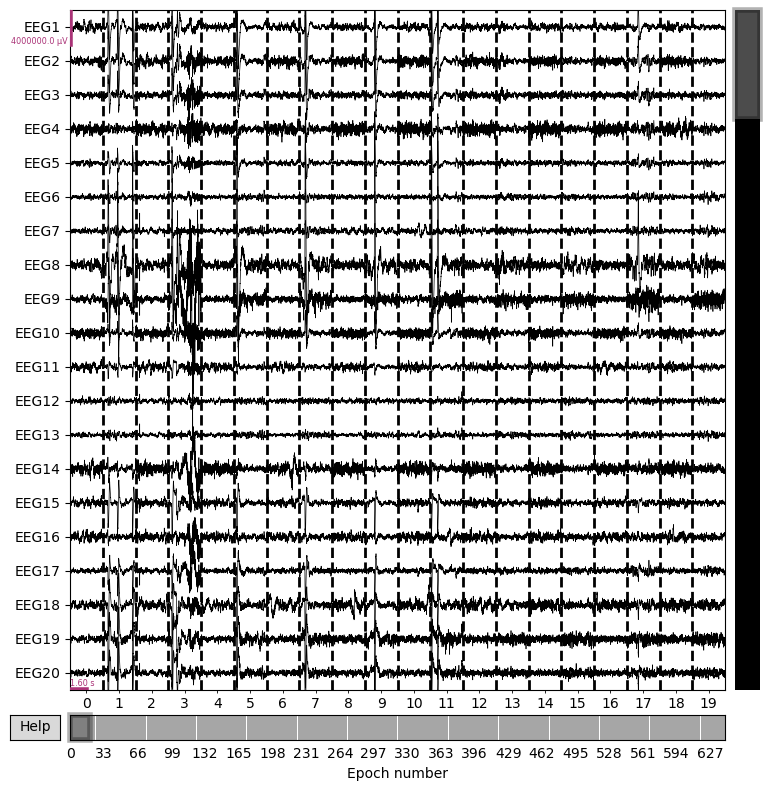

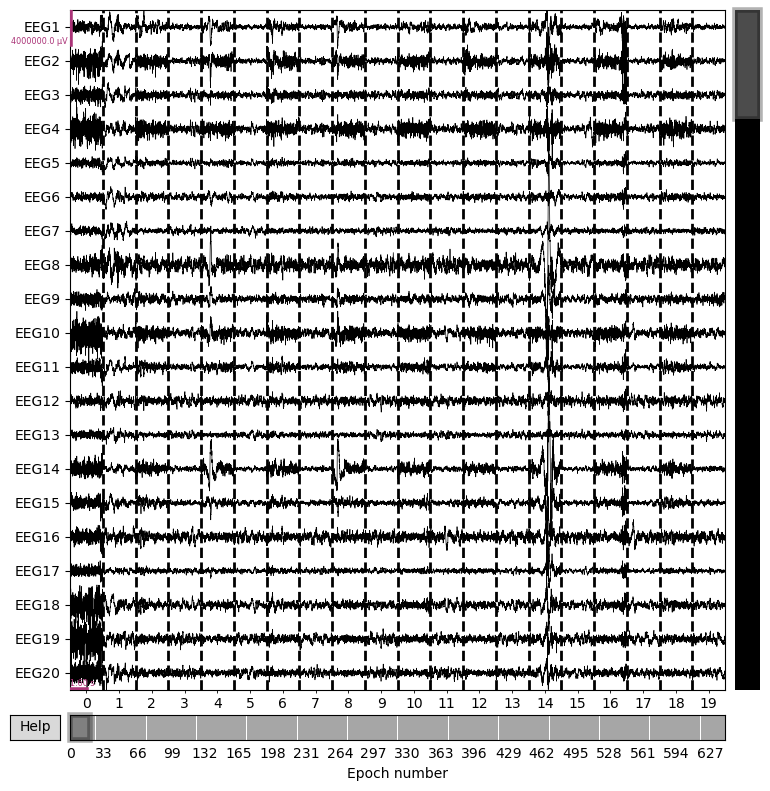

## Create Power Spectral Density (PSD)

In [ ]:
# -----------------------
#  STOP-IN :
# -----------------------

psd_alpha_si = ep_si.compute_psd(method='multitaper',fmin = 8.00, fmax=12.00, tmin=-0.8,tmax=0.0,picks='eeg')
psd_beta_si = ep_si.compute_psd(method='multitaper',fmin = 15.00, fmax=32.00, tmin=-0.8,tmax=0.0,picks='eeg')
psd_gamma_si = ep_si.compute_psd(method='multitaper',fmin = 40.00, fmax=80.00, tmin=-0.8,tmax=0.0,picks='eeg')


# -----------------------
#  PUNCH-TROUGH :
# -----------------------

psd_alpha_pt = ep_pt.compute_psd(method='multitaper',fmin = 8.00, fmax=12.00, tmin=-0.8,tmax=0.0,picks='eeg')
psd_beta_pt = ep_pt.compute_psd(method='multitaper',fmin = 15.00, fmax=32.00, tmin=-0.8,tmax=0.0,picks='eeg')
psd_gamma_pt = ep_pt.compute_psd(method='multitaper',fmin = 40.00, fmax=80.00, tmin=-0.8,tmax=0.0,picks='eeg')

Not setting metadata
642 matching events found
No baseline correction applied
Not setting metadata
642 matching events found
No baseline correction applied

## Make Hilbert Transformation 

In [ ]:
def compute_hilbert_correlation(psd_data):
    n_trials, n_channels, n_freqs = psd_data.shape
    correlation_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(n_channels):
            # Calculate the signal envelope using the Hilbert transform
            envelope_i = np.abs(hilbert(psd_data[:, i, :], axis=0))
            envelope_j = np.abs(hilbert(psd_data[:, j, :], axis=0))

            # Calculate the correlation between the envelopes
            correlation = np.corrcoef(envelope_i.flatten(), envelope_j.flatten())[0, 1]
            correlation_matrix[i, j] = correlation

    return correlation_matrix

def plot_correlation_matrix(correlation_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
    plt.title(title)
    plt.xlabel('Electrodes')
    plt.ylabel('Electrodes')
    plt.show()

In [ ]:
def compute_and_plot_hilbert_envelope(psd_data, channel_i, channel_j):
    # Calculate the signal envelope using the Hilbert transform
    envelope_i = np.abs(hilbert(psd_data[:, channel_i, :], axis=0))
    envelope_j = np.abs(hilbert(psd_data[:, channel_j, :], axis=0))

    # Plot the envelope for the two electrodes
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(envelope_i)
    plt.title(f'Signal Envelope for Electrode {channel_i}')
    plt.xlabel('Trial')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(envelope_j)
    plt.title(f'Signal Envelope for Electrode {channel_j}')
    plt.xlabel('Trial')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def compute_and_plot_mean_hilbert_envelope(psd_data, channel_i, channel_j):
    # Calculate the signal envelope using the Hilbert transform
    envelope_i = np.abs(hilbert(psd_data[:, channel_i, :], axis=0))
    envelope_j = np.abs(hilbert(psd_data[:, channel_j, :], axis=0))

    # Average the envelope over all frequencies
    mean_envelope_i = np.mean(envelope_i, axis=1)
    mean_envelope_j = np.mean(envelope_j, axis=1)

    # Plot the mean envelope for the two electrodes
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(mean_envelope_i)
    plt.title(f'Mean Signal Envelope for Electrode {channel_i}')
    plt.xlabel('Trial')
    plt.ylabel('Mean Amplitude')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(mean_envelope_j)
    plt.title(f'Mean Signal Envelope for Electrode {channel_j}')
    plt.xlabel('Trial')
    plt.ylabel('Mean Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def extract_features(correlation_matrix):
    # Extract values from the upper triangular matrix (excluding the diagonal)
    upper_triangle = correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]
    return upper_triangle

## Extracting best features for each movement and each band

### STOP-IN

In [ ]:
# Calculate the correlation for each frequency band
corr_alpha_si = compute_hilbert_correlation(psd_alpha_si.get_data())

# Plot the correlation matrices for each frequency band
plot_correlation_matrix(corr_alpha_si, 'Correlation Matrix - Alpha Band SI')

# Example usage for a specific pair of electrodes
channel_i = 10  # Replace with the index of the desired electrode
channel_j = 20  # Replace with the index of the desired electrode

# Calculate and plot the envelope for the alpha band
compute_and_plot_hilbert_envelope(psd_alpha_si.get_data(), channel_i, channel_j)

# Calculate and plot the mean envelope for the alpha band
compute_and_plot_mean_hilbert_envelope(psd_alpha_si.get_data(), channel_i, channel_j)

# Extract features for each frequency band
features_alpha_si = extract_features(corr_alpha_si)  # No averaging needed



# Calculate the correlation for each frequency band
corr_beta_si = compute_hilbert_correlation(psd_beta_si.get_data())

# Plot the correlation matrices for each frequency band
plot_correlation_matrix(corr_beta_si, 'Correlation Matrix - Beta Band SI')

# Example usage for a specific pair of electrodes
channel_i = 10  # Replace with the index of the desired electrode
channel_j = 20  # Replace with the index of the desired electrode

# Calculate and plot the envelope for the beta band
compute_and_plot_hilbert_envelope(psd_beta_si.get_data(), channel_i, channel_j)

# Calculate and plot the mean envelope for the beta band
compute_and_plot_mean_hilbert_envelope(psd_beta_si.get_data(), channel_i, channel_j)

# Extract features for each frequency band
features_beta_si = extract_features(corr_beta_si)  # No averaging needed



# Calculate the correlation for each frequency band
corr_gamma_si = compute_hilbert_correlation(psd_gamma_si.get_data())

# Plot the correlation matrices for each frequency band
plot_correlation_matrix(corr_gamma_si, 'Correlation Matrix - Gamma Band SI')

# Example usage for a specific pair of electrodes
channel_i = 10  # Replace with the index of the desired electrode
channel_j = 20  # Replace with the index of the desired electrode

# Calculate and plot the envelope for the gamma band
compute_and_plot_hilbert_envelope(psd_gamma_si.get_data(), channel_i, channel_j)

# Calculate and plot the mean envelope for the gamma band
compute_and_plot_mean_hilbert_envelope(psd_gamma_si.get_data(), channel_i, channel_j)

# Extract features for each frequency band
features_gamma_si = extract_features(corr_gamma_si)  # No averaging needed





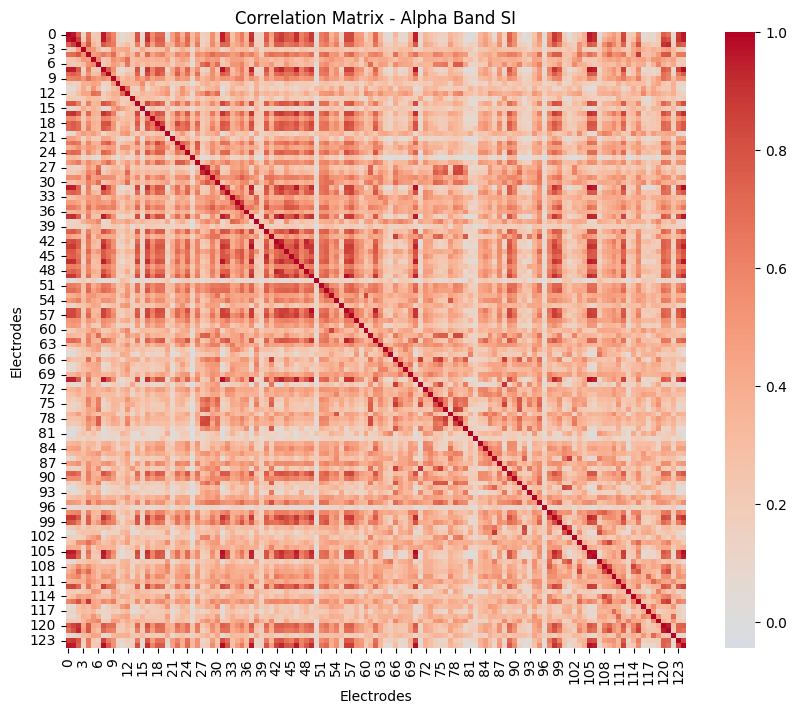    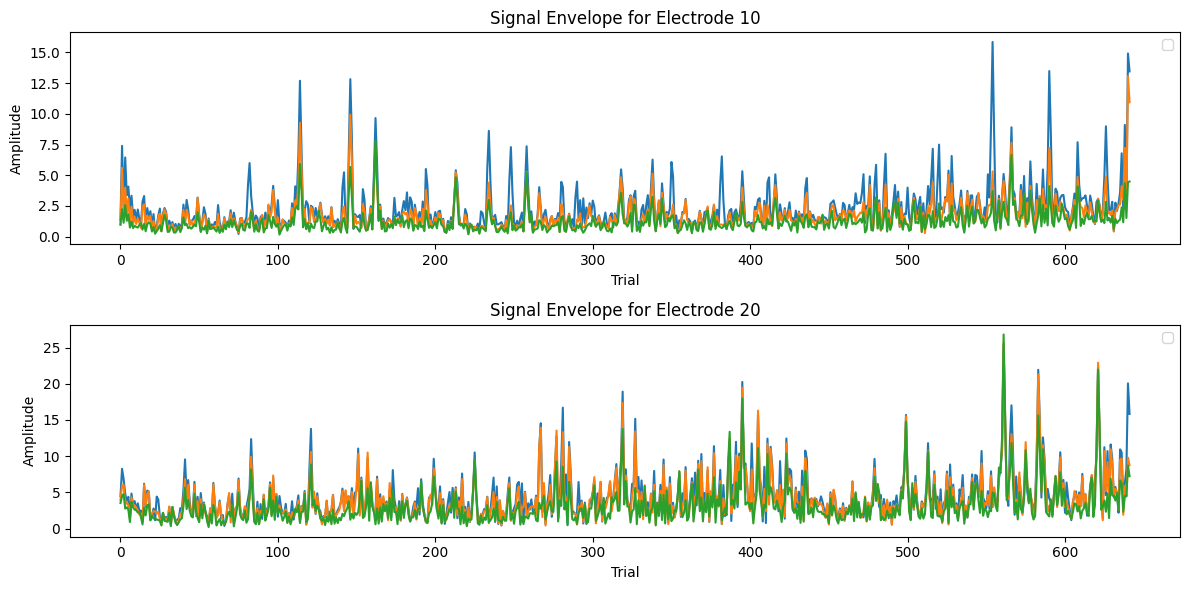   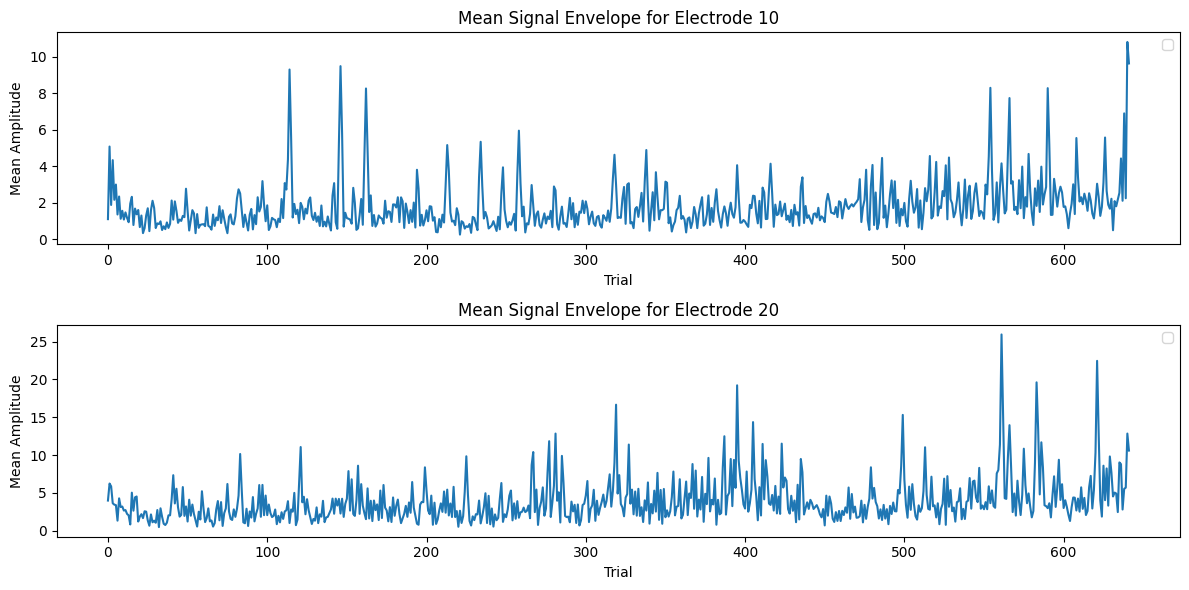  

### PUNCH-TROUGH

In [ ]:
# Calculate the correlation for each frequency band
corr_alpha_pt = compute_hilbert_correlation(psd_alpha_pt.get_data())

# Plot the correlation matrices for each frequency band
plot_correlation_matrix(corr_alpha_pt, 'Correlation Matrix - Alpha Band PT')

# Example usage for a specific pair of electrodes
channel_i = 10  # Replace with the index of the desired electrode
channel_j = 20  # Replace with the index of the desired electrode

# Calculate and plot the envelope for the alpha band
compute_and_plot_hilbert_envelope(psd_alpha_pt.get_data(), channel_i, channel_j)

# Calculate and plot the mean envelope for the alpha band
compute_and_plot_mean_hilbert_envelope(psd_alpha_pt.get_data(), channel_i, channel_j)

# Extract features for each frequency band
features_alpha_pt = extract_features(corr_alpha_pt)  # No averaging needed

# Calculate the correlation for each frequency band
corr_beta_pt = compute_hilbert_correlation(psd_beta_pt.get_data())

# Plot the correlation matrices for each frequency band
plot_correlation_matrix(corr_beta_pt, 'Correlation Matrix - Beta Band PT')

# Example usage for a specific pair of electrodes
channel_i = 10  # Replace with the index of the desired electrode
channel_j = 20  # Replace with the index of the desired electrode

# Calculate and plot the envelope for the beta band
compute_and_plot_hilbert_envelope(psd_beta_pt.get_data(), channel_i, channel_j)

# Calculate and plot the mean envelope for the beta band
compute_and_plot_mean_hilbert_envelope(psd_beta_pt.get_data(), channel_i, channel_j)

# Extract features for each frequency band
features_beta_pt = extract_features(corr_beta_pt)  # No averaging needed



# Calculate the correlation for each frequency band
corr_gamma_pt = compute_hilbert_correlation(psd_gamma_pt.get_data())

# Plot the correlation matrices for each frequency band
plot_correlation_matrix(corr_gamma_pt, 'Correlation Matrix - Gamma Band PT')

# Example usage for a specific pair of electrodes
channel_i = 10  # Replace with the index of the desired electrode
channel_j = 20  # Replace with the index of the desired electrode

# Calculate and plot the envelope for the gamma band
compute_and_plot_hilbert_envelope(psd_gamma_pt.get_data(), channel_i, channel_j)

# Calculate and plot the mean envelope for the gamma band
compute_and_plot_mean_hilbert_envelope(psd_gamma_pt.get_data(), channel_i, channel_j)

# Extract features for each frequency band
features_gamma_pt = extract_features(corr_gamma_pt)  # No averaging needed

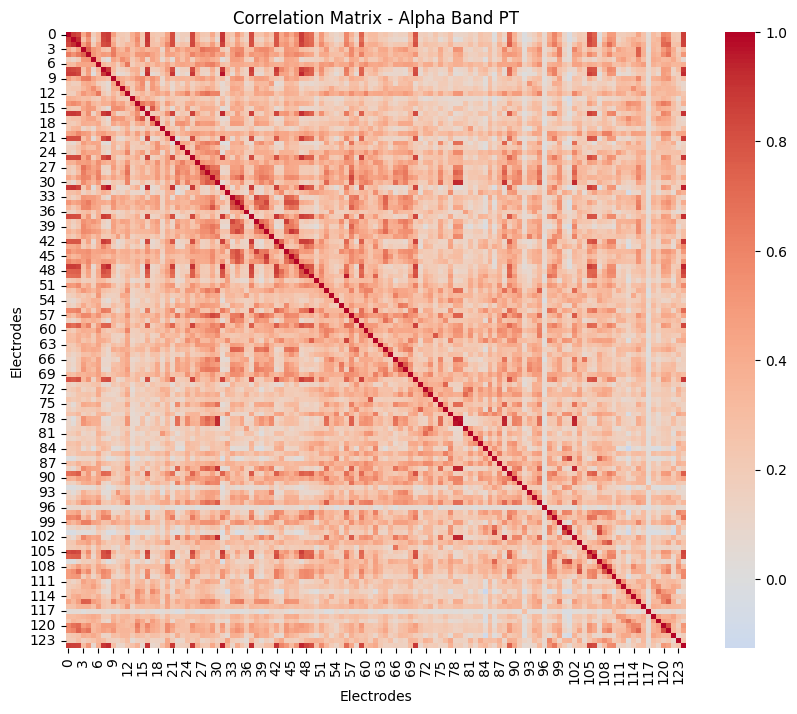   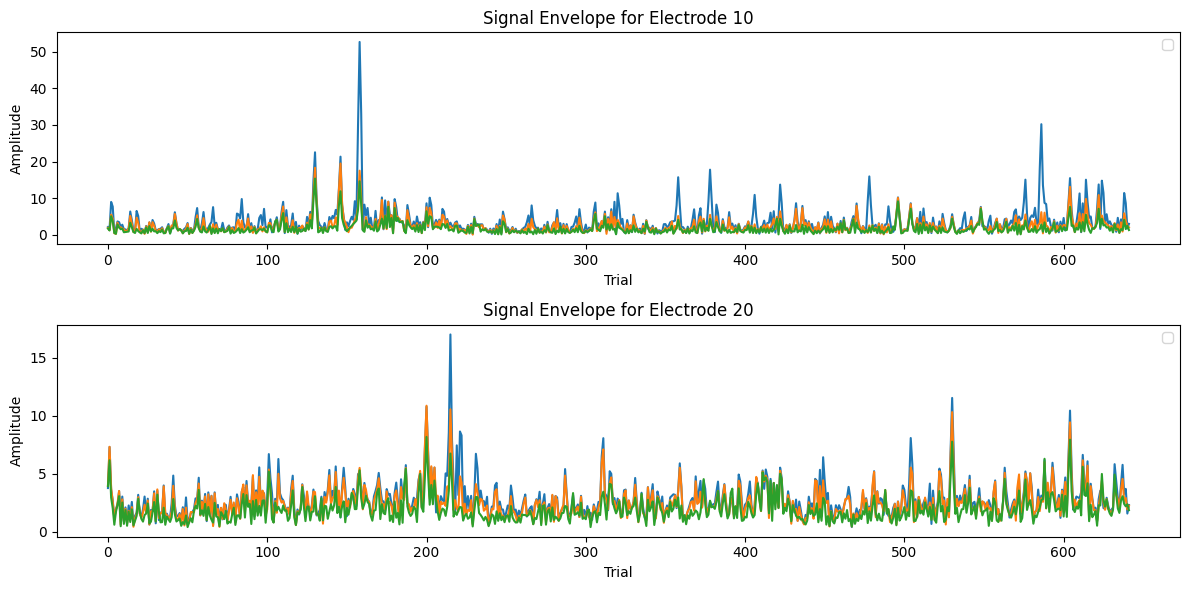   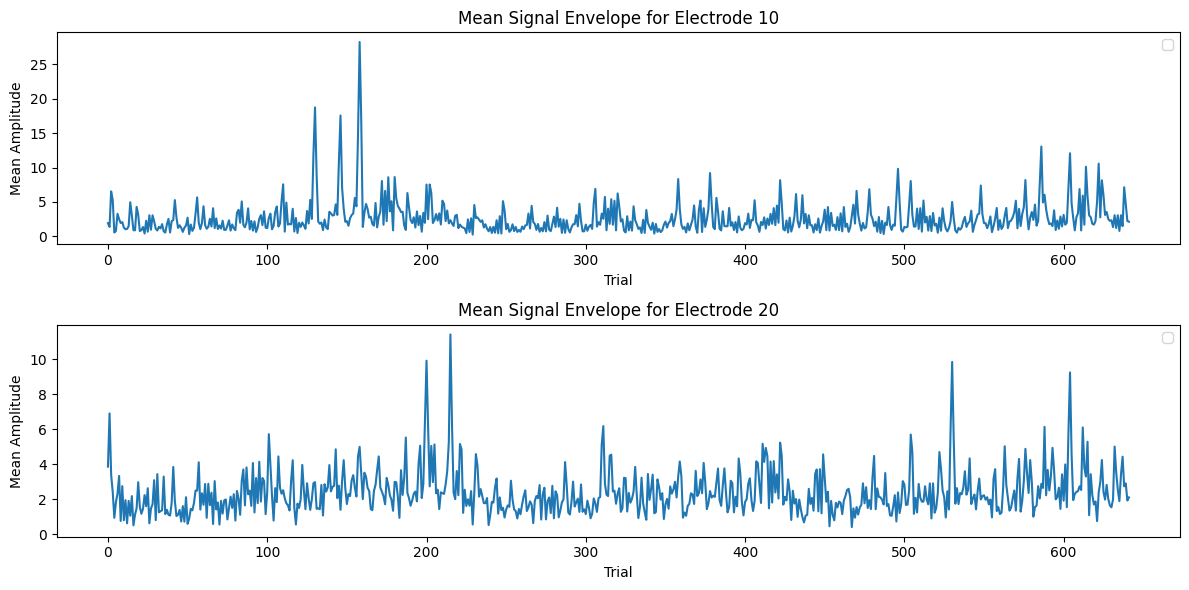 